In [74]:
%matplotlib notebook

In [77]:
import calour as ca
import numpy as np
import pandas as pd
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve, auc
from emperor import Emperor, nbinstall
from calour.training import plot_roc
import matplotlib.pyplot as plt

In [78]:
exp = ca.read('data/metabolome/features_TSNnorm.txt', 'data/combined_sample_metadata_HFD.txt',
             normalize=100, feature_metadata_file='data/metabolome/annotations_wStandards.txt')

exp = exp.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

2018-08-24 15:40:51 WARNING These have metadata but do not have data - dropped (343): {'11548.A23.117.14', '11548.A22.115.4', '11548.A22.113.3', '11548.A18.97.17', '11548.A20.107.16', '11548.A18.99.19', '11548.A23.117.17', '11548.A18.99.8', '11548.A19.101.8', '11548.A22.113.19', '11548.A20.105.17', '11548.A23.120.17', '11548.A21.109.12', '11548.A21.110.14', '11548.A22.115.6', '11548.A19.103.6', '11548.A20.108.11', '11548.A22.113.6', '11548.A23.120.3', '11548.A19.101.6', '11548.A22.116.16', '11548.A23.118.12', '11548.A22.115.14', '11548.A18.98.11', '11548.A21.111.11', '11548.A20.108.16', '11548.A18.99.2', '11548.A23.117.19', '11548.A22.115.16', '11548.A20.107.19', '11548.A18.98.4', '11548.A19.101.17', '11548.A21.112.4', '11548.A23.120.18', '11548.A18.98.9', '11548.A21.110.7', '11548.A21.111.16', '11548.A18.99.12', '11548.A23.118.3', '11548.A22.114.19', '11548.A19.103.2', '11548.A18.98.17', '11548.A20.108.13', '11548.A23.120.12', '11548.A18.100.3', '11548.A18.98.7', '11548.A23.120.4', '1

In [79]:
exp

Experiment ("features_TSNnorm.txt") with 299 samples, 1889 features

# PCoA

In [80]:
bc_dm = beta_diversity("euclidean", exp.data.todense(), validate=False)

In [26]:
bc_dm.ids = exp.sample_metadata.index

In [27]:
ordin = pcoa(bc_dm)

In [28]:
x = (Emperor(ordin, exp.sample_metadata, remote=True)
      .color_by('genotype', colormap='Dark2'))
x

In [29]:
exp.sample_metadata.genotype.value_counts()

LDLR KO    182
ApoE KO    117
Name: genotype, dtype: int64

# APOE and LDLR models

In [81]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'field'
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.1).filter_samples('age', [10, 10.5], 
                                                                                         negate=True)
exp2

Experiment ("features_TSNnorm.txt") with 263 samples, 377 features

In [82]:
# filter samples not labeled as Apoe or ldlr
exp2 = exp2.filter_samples('genotype', ['ApoE KO','LDLR KO'])

In [83]:
exp2.sample_metadata.genotype.value_counts()

LDLR KO    170
ApoE KO     93
Name: genotype, dtype: int64

In [84]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    48
IHH    45
Name: exposure_type, dtype: int64

In [85]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR KO')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

Air    85
IHH    85
Name: exposure_type, dtype: int64

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

## apoe to ldlr

In [87]:
it_apoe = exp2_apoe.classify('exposure_type',
                             RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_apoe.data, exp2_apoe.sample_metadata['exposure_type'], 
                                 exp2_apoe.sample_metadata['mouse_number']))

In [88]:
res_apoe = next(it_apoe)

In [89]:
res_apoe.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.424,0.576,IHH,11548.A19.101.5,0
1,0.174,0.826,IHH,11548.A19.101.10,0
2,0.030,0.970,IHH,11548.A19.101.20,0
3,0.060,0.940,IHH,11548.A19.101.15,0
4,0.868,0.132,Air,11548.A22.113.20,0


<IPython.core.display.Javascript object>


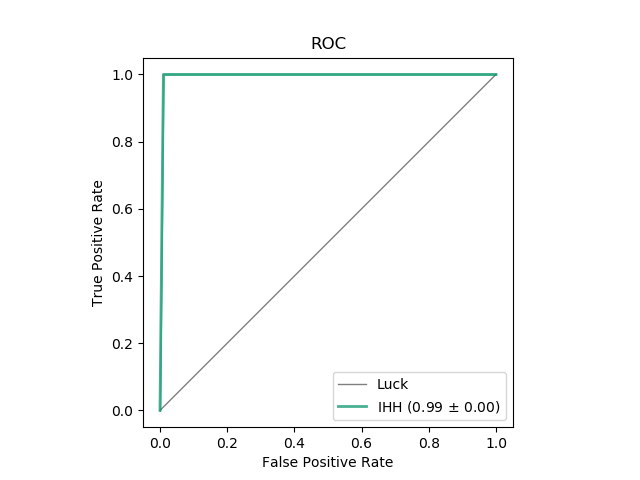

In [91]:
plot_roc(res_apoe, classes=['IHH'], cv=True)

In [92]:
clf_apoe = RandomForestClassifier(500, oob_score=True)
clf_apoe.fit(exp2_apoe.data, exp2_apoe.sample_metadata.exposure_type)
clf_apoe.oob_score_

1.0

In [93]:
res_apoe2ldlr = pd.DataFrame(clf_apoe.predict_proba(exp2_ldlr.data))
res_apoe2ldlr.columns = clf_apoe.classes_
res_apoe2ldlr['Y_TRUE'] = exp2_ldlr.sample_metadata['exposure_type'].values
res_apoe2ldlr['CV'] = 0

<IPython.core.display.Javascript object>


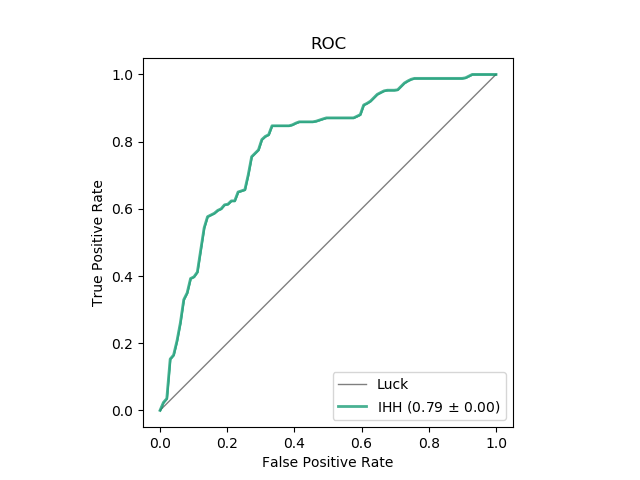

In [94]:
plot_roc(res_apoe2ldlr, classes=['IHH'])

## ldlr to apoe

In [95]:
it_ldlr = exp2_ldlr.classify('exposure_type', RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_ldlr.data, exp2_ldlr.sample_metadata['exposure_type'], exp2_ldlr.sample_metadata['mouse_number']))

In [96]:
res_ldlr = next(it_ldlr)

In [97]:
res_ldlr.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.124,0.876,IHH,10422.17.F.6,0
1,0.058,0.942,IHH,10422.17.F.12,0
2,0.098,0.902,IHH,10422.17.F.5,0
3,0.286,0.714,IHH,10422.17.F.3,0
4,0.106,0.894,IHH,10422.17.F.8,0


<IPython.core.display.Javascript object>


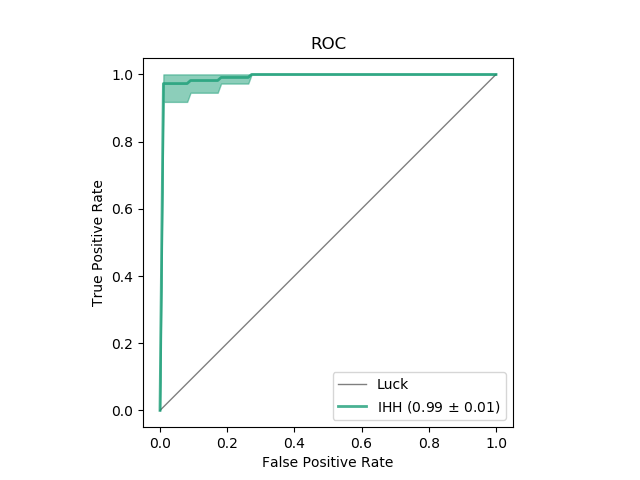

In [98]:
plot_roc(res_ldlr, classes=['IHH'])

In [99]:
clf_ldlr = RandomForestClassifier(500, oob_score=True)
clf_ldlr.fit(exp2_ldlr.data, exp2_ldlr.sample_metadata.exposure_type)
clf_ldlr.oob_score_

0.9647058823529412

In [100]:
res_ldlr2apoe = pd.DataFrame(clf_ldlr.predict_proba(exp2_apoe.data))
res_ldlr2apoe.columns = clf_ldlr.classes_
res_ldlr2apoe['Y_TRUE'] = exp2_apoe.sample_metadata['exposure_type'].values
res_ldlr2apoe['CV'] = 0

<IPython.core.display.Javascript object>


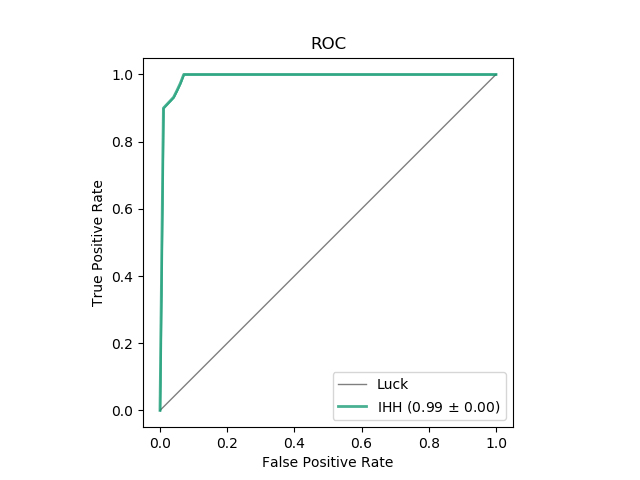

In [101]:
plot_roc(res_ldlr2apoe, classes=['IHH'])

# feature imp

In [38]:
imp = pd.DataFrame({'apoe': clf_apoe.feature_importances_,
                    'ldlr': clf_ldlr.feature_importances_})

In [39]:
imp_rank = imp.rank(ascending=False)

In [40]:
imp.head()

,apoe,ldlr
0,0.000933,0.000615
1,0.002455,0.000563
2,0.000084,0.006543
3,0.000000,0.001705
4,0.000000,0.000324


In [41]:
imp_rank.head()

,apoe,ldlr
0,90.0,217.0
1,58.0,234.0
2,241.0,34.0
3,323.5,91.0
4,323.5,308.0


In [42]:
plt.scatter(imp.apoe, imp.ldlr)

In [43]:
plt.scatter(imp_rank.apoe, imp_rank.ldlr)

In [44]:
exp2.feature_metadata['apoe_imp'] = imp.apoe.values
exp2.feature_metadata['ldlr_imp'] = imp.ldlr.values
exp2.feature_metadata['apoe_imp_rank'] = imp_rank.apoe.values
exp2.feature_metadata['ldlr_imp_rank'] = imp_rank.ldlr.values

2018-08-01 13:18:20 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


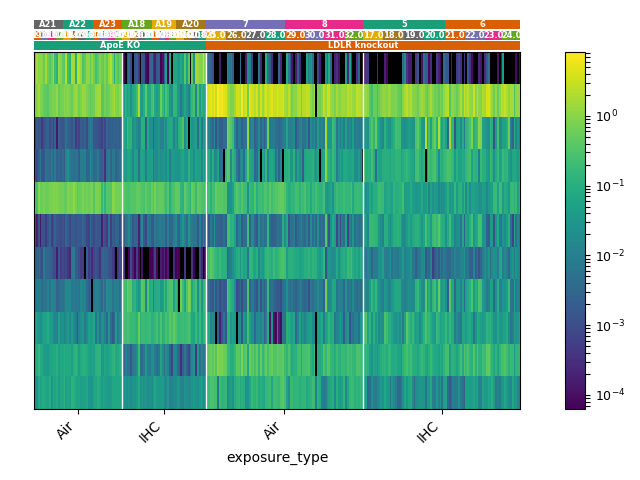

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [45]:
# feature important for both models (in top 50 in both)
n = 50
exp3 = (exp2.filter_by_metadata('ldlr_imp_rank', lambda x: [i < n for i in x], axis=1)
         .filter_by_metadata('apoe_imp_rank', lambda x: [i < n for i in x], axis=1))
(exp3
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [108]:
import pickle
with open('common-imp-metabs.pkl', 'wb') as f:
    pickle.dump(exp3, f)

In [46]:
exp3.feature_metadata.columns

Index(['row ID', 'row m/z', 'row retention time', 'LibraryID',
       'standard_indentification_level_1', '_feature_id', 'apoe_imp',
       'ldlr_imp', 'apoe_imp_rank', 'ldlr_imp_rank'],
      dtype='object')

In [47]:
features = []
for i in exp3.feature_metadata.index:
    df = pd.DataFrame({'abundance': exp3[:, i],
                       'taxonomy': exp3.feature_metadata.loc[i, 'LibraryID'],
                       'standard_BA': exp3.feature_metadata.loc[i, 'standard_indentification_level_1'],
                       'genotype': exp3.sample_metadata['genotype'],
                       'age': exp3.sample_metadata['age'],
                       'exposure_type': exp3.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-metabs.tsv', sep='\t')

2018-08-01 13:19:10 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


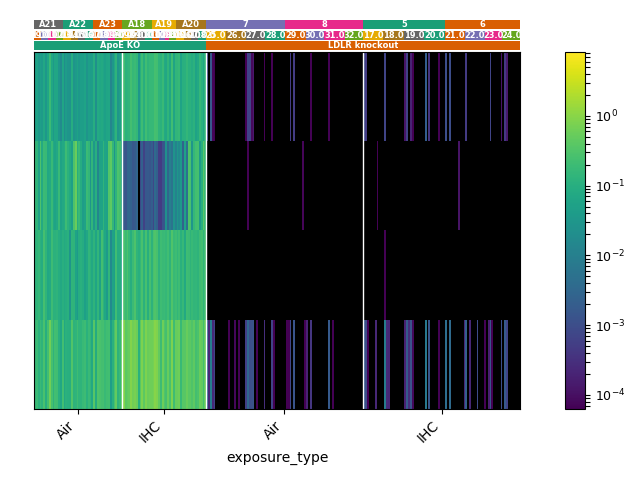

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [50]:
# feature not important for ldlr but in top 100 in apoe
n=100
(exp2.filter_by_metadata('ldlr_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('apoe_imp_rank', lambda x: [i < 100 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [51]:
# feature not important for apoe but in top 50 in ldlr
(exp2.filter_by_metadata('apoe_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('ldlr_imp_rank', lambda x: [i < 50 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', 
           barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

2018-08-01 13:19:25 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

# diff abundance

In [52]:
exp2_apoe_diff = exp2_apoe.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

2018-08-01 13:19:42 WARNING Do you forget to normalize your data? It is required before running this function


In [53]:
exp2_ldlr_diff = exp2_ldlr.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

2018-08-01 13:19:42 WARNING Do you forget to normalize your data? It is required before running this function


In [54]:
fids = set(exp2_apoe_diff.feature_metadata.index) & set(exp2_ldlr_diff.feature_metadata.index)

In [55]:
len(fids)

52

In [56]:
exp2.shape

(263, 377)

In [57]:
features = []
for i in fids:
    df = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': exp2.feature_metadata.loc[i, 'LibraryID'],
                       'standard_BA': exp2.feature_metadata.loc[i, 'standard_indentification_level_1'],
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-diff-metabs.tsv', sep='\t')

In [58]:
from sklearn.metrics import roc_auc_score

In [59]:
highpred = []
for i in fids:
    taxon = exp2_apoe.feature_metadata.loc[i, 'LibraryID']
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    a = roc_auc_score(apoe_true, apoe_score)
    if a < 0.5:
        a = 1 - a
    t1 = a
    print('-------')
    print(taxon)
    print(i)
    print('APOE: {:.3f}'.format(a))
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    a = roc_auc_score(ldlr_true, ldlr_score)
    if a < 0.5:
        a = 1 - a
    t2 = a
    print('LDLR: {:.3f}'.format(a))
    
    # features with greater than 80% accuracy in both models
    if t1>0.75 and t2>0.75:
        highpred.append(i)

-------
cis-Vaccenic acid
265.25244007223137_5.432108840227089
APOE: 0.971
LDLR: 0.777
-------
nan
601.5399281469334_5.45405833333333
APOE: 0.762
LDLR: 0.771
-------
nan
589.30170307438_3.7674697944593385
APOE: 0.732
LDLR: 0.649
-------
nan
391.2843719708507_4.369248333333332
APOE: 0.803
LDLR: 0.735
-------
nan
389.2690331387742_3.437795402298853
APOE: 0.871
LDLR: 0.804
-------
Spectral Match to Cholic acid from NIST14
373.2737632068537_3.6807178630363
APOE: 0.859
LDLR: 0.719
-------
nan
374.27706481344507_3.9006440359477117
APOE: 0.752
LDLR: 0.744
-------
Methyl 12-hydroxystearate
297.27825689035825_5.705698658536578
APOE: 0.971
LDLR: 0.689
-------
.beta.-Muricholic acid
373.2738491153533_3.899919847020934
APOE: 0.733
LDLR: 0.731
-------
nan
326.37793168777256_5.5902060067681925
APOE: 0.738
LDLR: 0.741
-------
.beta.-Muricholic acid
373.2738348512753_3.8372961569579247
APOE: 0.796
LDLR: 0.782
-------
nan
376.2924729358175_4.740066617790812
APOE: 0.741
LDLR: 0.862
-------
nan
514.28396

In [60]:
len(highpred)

20

In [61]:
exp2_com = exp2.filter_ids(highpred,
                           axis=1)

<IPython.core.display.Javascript object>


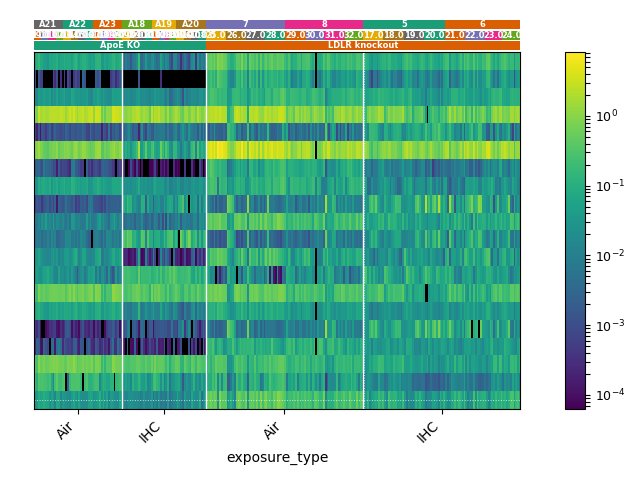

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [62]:
(exp2_com
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     #.cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], 
           gui='jupyter'))

# roc curvse

<IPython.core.display.Javascript object>


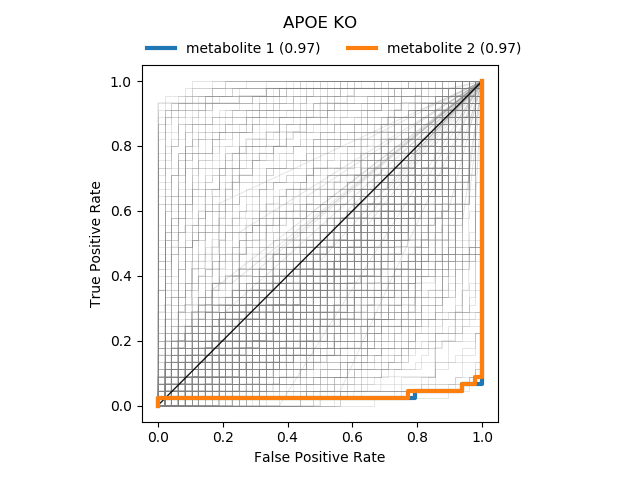

Text(0.5,1.08,'APOE KO')

In [102]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')

fids_apoe = []
auc_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
        auc_apoe.append(a)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.2)

ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO', y=1.08)

<IPython.core.display.Javascript object>


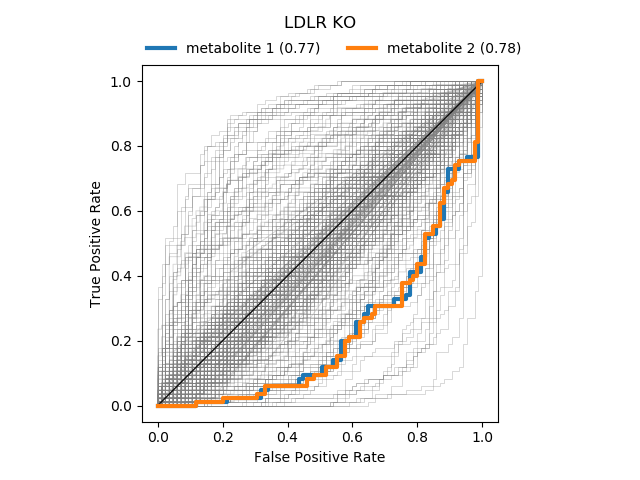

Text(0.5,1.08,'LDLR KO')

In [103]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []
auc_ldlr = []
for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
        auc_ldlr.append(a)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.3)

ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO', y=1.08)

In [104]:
exp2.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id
#featureID,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452


In [133]:
df1 = pd.DataFrame({'auc': auc_apoe, 'id': fids_apoe})
df2 = pd.DataFrame({'auc': auc_ldlr, 'id': fids_ldlr})

df = pd.merge(df1, df2, 'inner',  left_on='id', right_on='id', suffixes=('_ApoE', '_LDLR'))
df['sum_auc'] = df['auc_ApoE'] + df['auc_LDLR']
df['annot'] = exp2.feature_metadata.loc[df['id'], 'LibraryID'].values
df['annot2'] = exp2.feature_metadata.loc[df['id'], 'standard_indentification_level_1'].values
df.set_index('id', inplace=True)
df.sort_values('sum_auc', ascending=False, kind='mergesort', inplace=True)
df.sort_values('annot', ascending=False, kind='mergesort', inplace=True)


In [134]:
df

,auc_ApoE,auc_LDLR,sum_auc,annot,annot2
id,,,,,
283.2629498309951_5.430859365079369,0.971759,0.774118,1.745877,trans-Vaccenic acid,NaN
265.25244007223137_5.432108840227089,0.970833,0.776609,1.747442,cis-Vaccenic acid,NaN
255.2317783582418_5.1814566985645945,0.978241,0.751280,1.729521,cis-9-Hexadecenoic acid,NaN
516.300422276808_3.5346080964685593,0.962500,0.823806,1.786306,Spectral Match to Taurocholic acid from NIST14,NaN
516.3001954425159_3.6121693593314776,0.806944,0.831557,1.638502,Spectral Match to Taurocholic acid from NIST14,NaN
355.2633984884364_3.811552948402946,0.864815,0.826436,1.691251,Spectral Match to Cholic acid from NIST14,a-Muricholic acid
332.3307817246258_5.3103554720133594,0.750463,0.871003,1.621466,Spectral Match to Benzyltetradecyldimethylammo...,NaN
373.2738348512753_3.8372961569579247,0.796296,0.782007,1.578303,.beta.-Muricholic acid,a-Muricholic acid
423.2744890715284_4.29798541001065,0.919907,0.932318,1.852226,NaN,NaN


In [121]:
df.to_csv('metabolites.tsv', sep='\t')

In [137]:
row1, row2 = df.iloc[1].copy(), df.iloc[5].copy()
df.iloc[1],df.iloc[5] = row2,row1

In [135]:
df['annot'][pd.notnull(df['annot2'])] = df['annot2']
df

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,auc_ApoE,auc_LDLR,sum_auc,annot,annot2
id,,,,,
283.2629498309951_5.430859365079369,0.971759,0.774118,1.745877,trans-Vaccenic acid,NaN
265.25244007223137_5.432108840227089,0.970833,0.776609,1.747442,cis-Vaccenic acid,NaN
255.2317783582418_5.1814566985645945,0.978241,0.751280,1.729521,cis-9-Hexadecenoic acid,NaN
516.300422276808_3.5346080964685593,0.962500,0.823806,1.786306,Spectral Match to Taurocholic acid from NIST14,NaN
516.3001954425159_3.6121693593314776,0.806944,0.831557,1.638502,Spectral Match to Taurocholic acid from NIST14,NaN
355.2633984884364_3.811552948402946,0.864815,0.826436,1.691251,a-Muricholic acid,a-Muricholic acid
332.3307817246258_5.3103554720133594,0.750463,0.871003,1.621466,Spectral Match to Benzyltetradecyldimethylammo...,NaN
373.2738348512753_3.8372961569579247,0.796296,0.782007,1.578303,a-Muricholic acid,a-Muricholic acid
423.2744890715284_4.29798541001065,0.919907,0.932318,1.852226,NaN,NaN


In [122]:
fids = list(set(fids_apoe) & set(fids_ldlr))

In [123]:
fids.sort()

In [124]:
len(fids)

20

In [125]:
print(fids)

['255.2317783582418_5.1814566985645945', '265.25244007223137_5.432108840227089', '283.2629498309951_5.430859365079369', '324.28986215556387_5.433176666666667', '332.3307817246258_5.3103554720133594', '355.2633984884364_3.811552948402946', '373.2738348512753_3.8372961569579247', '374.2771151341289_3.8368078358208924', '389.2690331387742_3.437795402298853', '389.2691196723436_3.383737479270316', '407.2793260908103_3.6924033502968627', '407.279362595115_3.601989730639734', '423.2744890715284_4.29798541001065', '506.27911240204685_3.7126306003584237', '514.283968153228_3.3051131999999996', '516.3001954425159_3.6121693593314776', '516.300422276808_3.5346080964685593', '533.3268329649845_3.536782531194295', '568.3396247335379_5.054229002624673', '601.5399281469334_5.45405833333333']


In [181]:
exp2_apoe[:,fids[4]] > 0

array([ True,  True, False,  True, False, False,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True, False, False,  True, False,  True, False,  True,  True,
       False, False,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

<IPython.core.display.Javascript object>


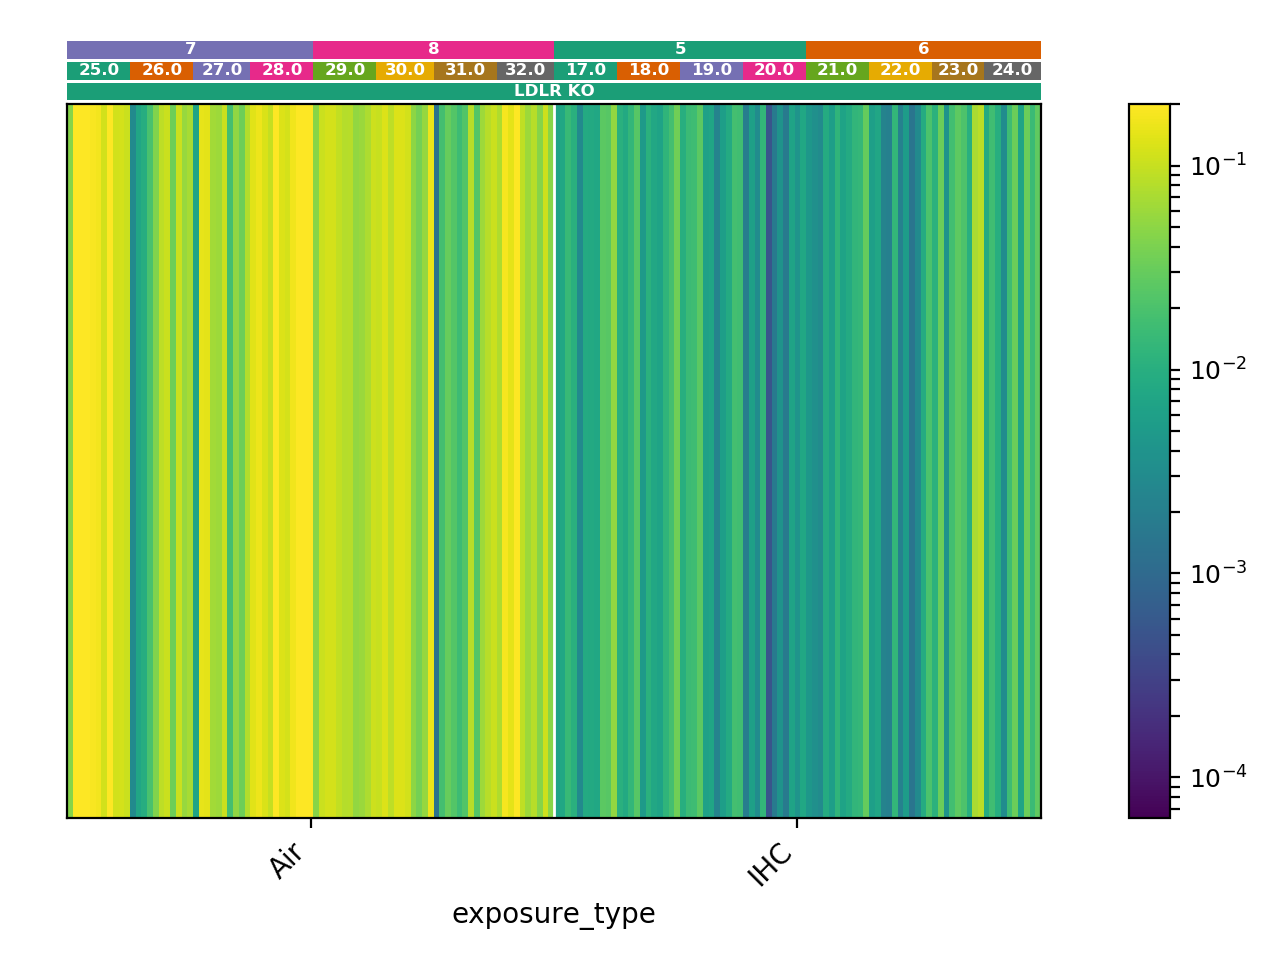

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [174]:
(exp2_ldlr.filter_ids(fids[4:5])
      .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
         .plot(sample_field='exposure_type', 
           barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter', clim=[0, 0.2]))

<IPython.core.display.Javascript object>


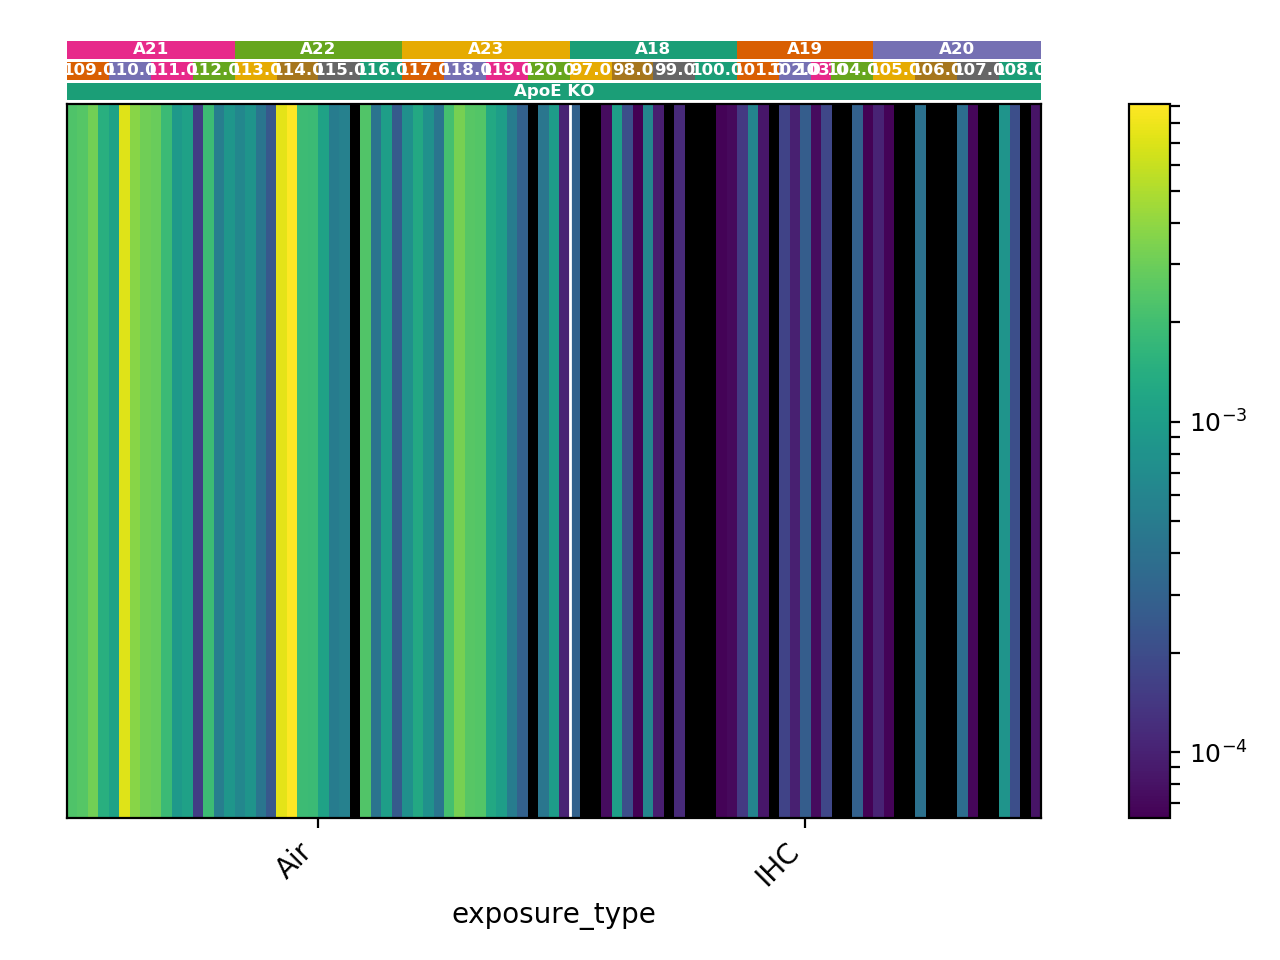

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [168]:
(exp2_apoe.filter_ids(fids[4:5])
      .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
         .plot(sample_field='exposure_type', 
           barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [54]:
exp2.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id
#featureID,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452


In [143]:
features = []
for n, i in enumerate(df.index, 1):
    annot = df.loc[i, 'annot']
    if isinstance(annot, float) and np.isnan(annot):
        annot = '%f_%f' % (exp2.feature_metadata.loc[i, 'row m/z'], exp2.feature_metadata.loc[i, 'row retention time'])
    df_ = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': 'metabolite %d: ' % n + annot,
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    features.append(df_)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-metabolites2.tsv', sep='\t')

In [145]:
for n, i in enumerate(df.index, 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

In [146]:
for n, i in enumerate(df.index, 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_ldlr.tight_layout()

In [147]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('roc-metabites2.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)

In [194]:
exp2_apoe.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id
#featureID,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452


In [148]:
!open roc-metabites2.pdf

## r plot


In [149]:
!open trend-metabolites2.pdf

In [271]:
!open trend-metabolites-colors.pdf